## 汽油辛烷值优化建模

以下解题过程中：
+ 参数定义
    - 《附件一：325个样本数据.xlsx》以符号 $\displaystyle{\mathcal{X}}_{s}$ 表示
    - 《附件三：285号和313号样本原始数据.xlsx》以符号 $\displaystyle{\mathcal{X}}_{r}$ 表示

In [1]:
sample_data = "../附件一：325个样本数据.xlsx"
raw_data = "../附件三：285号和313号样本原始数据.xlsx"
adjust_data = "../附件四：354个操作变量信息.xlsx"

### 问题一：

数据处理：请参考近4年的工业数据(见附件一“325个数据样本数据.xlsx”)的预处理结果，依“样本确定方法”（附件二）对285号和313号数据样本进行预处理（原始数据见附件三“285号和313号样本原始数据.xlsx”）并将处理后的数据分别加入到附件一中相应的样本号中，供下面研究使用。

即 数据预处理 ====> 补全数据&修正数据

解题思路：

+ 认真阅读《附件二：样本确定方法.docx》
+ 补全数据：
    - 即需要先确认 样本数据集 $\displaystyle{\mathcal{X}}_{s}$ 中 285号 $x_{s}^{(285)}$ 和 313号 $x_{s}^{(313)}$ 存在属性值缺失的属性集合 $\displaystyle{\mathcal{D}}_{loss}$
    - 将缺失的属性集合 $\displaystyle{\mathcal{D}}_{loss}$ 中的缺失的属性值从原始数据集中以求取均值 mean($\displaystyle{\mathcal{V}_{r}}$) 的方式确定
+ 修正数据：
    - 即需要先确认 原始数据集 $\displaystyle{\mathcal{X}}_{r}$ 中 285号 $x_{s}^{(285)}$ 和 313号 $x_{s}^{(313)}$ 样本中各属性的属性值缺失情况，对于缺失情况较大的属性则不对 样本数据集 中的属性值进行修正
    - 将 285号 $x_{s}^{(285)}$ 和 313号 $x_{s}^{(313)}$ 样本中需要修正的属性采用 变异系数 来判断是否存在奇异值，如果存在，则进行去除奇异值的操作，然后使用最大最小限幅的方式剔除一些不在范围内的样本，并最终将 变异系数 修正到合适的阈值，然后进行求取均值的操作

代码逻辑：

+ 首先从 样本数据集 $\displaystyle{\mathcal{X}}_{sample}$ 中确定样本 285号 $x_{sample}^{(285)}$ 和 313号 $x_{sample}^{(313)}$ 缺失的属性 $\displaystyle{\mathcal{D}}_{loss}$
+ 然后对缺失的属性 $d_{loss} \in \displaystyle{\mathcal{D}}_{loss}$ 对应到 原始数据集 $\displaystyle{\mathcal{X}}_{raw}$ 中，逐一对每个缺失的属性值进行判别
    - 这里使用 $\frac{\displaystyle{\mathbb{I}}(v_{loss}^{(i)} \ne 0|d_{loss}^{(i)})}{\displaystyle{\mathbb{I}}(v_{loss}^{(i)} |d_{loss}^{(i)})}$ 对当前 缺失的属性 $d_{loss}$ 在 原始数据集 $\displaystyle{\mathcal{X}}_{raw}$ 中数据采集的状况进行评估
        + 当比值 $ \ge \frac{3}{4} $ 时，对当前 缺失的属性的值 $d_{loss}$ 进行求均值 $v_{mean}^{(d_{loss})}$ 处理；
        + 当比值 $ < \frac{3}{4} $ 时，对当前 缺失的属性 $d_{loss}$ 进行直接忽略处理；
+ 对样本 $x_{sample}^{(i)}$ 进行 缺失的属性 $d_{loss}$ 求均值之前需进行异常值处理
    - 根据拉依达准则（3$\sigma$准则）去除异常值，得到 缺失的属性 $d_{loss}$ 对应的过滤后的 原始属性值集合 $\displaystyle{\mathcal{V}}_{filter}^{d_{loss}}$
    - 将处理后的 原始属性值集合 $\displaystyle{\mathcal{V}}_{filter}^{d_{loss}}$ 中的属性值进行求 均值 $\displaystyle{\mathcal{V}}_{filter_{mean}}^{d_{loss}}$ 操作加入到 $\displaystyle{\mathcal{X}}_{sample}$ 中对应的 样本数据 $x_{sample}^{(i)}$ 对应的 缺失的属性 $d_{loss}$ 中

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
raws = pd.read_excel(io=raw_data, sheet_name="操作变量", header=[0, 1], skiprows=[0])
samples = pd.read_excel(io=sample_data, header=[0, 1], skiprows=[0])

# 查看 原始数据情况
# raws 
# 查看 样本数据情况
# samples

In [4]:
# No.285 样本
sample_285 = samples.iloc[284]
sample_285 = sample_285.drop(index=sample_285.index[[x for x in range(1, 16)]], axis=1)
# No.313 样本
sample_313 = samples.iloc[312]
sample_313 = sample_313.drop(index=sample_285.index[[x for x in range(1, 16)]], axis=1)

# 查看 No.285 数据情况
# sample_285
# 查看 No.313 数据情况
# sample_313

In [5]:
def find_dummy_colmuns(sample):
    dummy_columns = []
    for (code_name, i18n_name) in sample.keys():
        if not sample[(code_name, i18n_name)]:
            # 查看 样本属性值 为 0 的列名
            # print(f"{'='*10}{i18n_name}{'='*10}")
            # print(f"{code_name}: => {sample[(code_name, i18n_name)]}")
            # print(f"{'='*35}")
            dummy_columns.append(code_name)
    return dummy_columns

In [6]:
sample_285_dummy_columns = find_dummy_colmuns(sample_285)
sample_313_dummy_columns = find_dummy_colmuns(sample_313)

# 查看 No.285 属性值为空的情况
print(f"No.285 属性值为空的列: {sample_285_dummy_columns}")
# 查看 No.313 属性值为空的情况
print(f"No.313 属性值为空的列: {sample_313_dummy_columns}")

No.285 属性值为空的列: ['S-ZORB.FT_1501.PV', 'S-ZORB.FT_1002.PV', 'S-ZORB.FC_1202.PV', 'S-ZORB.FT_1501.TOTAL', 'S-ZORB.FT_5102.PV', 'S-ZORB.FT_2901.DACA', 'S-ZORB.FC_1104.DACA', 'S-ZORB.FT_2803.DACA', 'S-ZORB.FT_1502.DACA', 'S-ZORB.TEX_3103A.DACA', 'S-ZORB.FT_5102.DACA.PV']
No.313 属性值为空的列: ['S-ZORB.FT_1501.PV', 'S-ZORB.FT_1002.PV', 'S-ZORB.FT_1501.TOTAL', 'S-ZORB.FT_2901.DACA', 'S-ZORB.FC_1104.DACA', 'S-ZORB.FT_2803.DACA', 'S-ZORB.FT_1502.DACA', 'S-ZORB.TEX_3103A.DACA']


In [7]:
# 拆分原始数据中285号样本的数据
print("拆分出来的285号样本的原始数据")
raw_285 = raws.iloc[:40]
raw_285[sample_285_dummy_columns].head(n=5)

拆分出来的285号样本的原始数据


,S-ZORB.FT_1501.PV,S-ZORB.FT_1002.PV,S-ZORB.FC_1202.PV,S-ZORB.FT_1501.TOTAL,S-ZORB.FT_5102.PV,S-ZORB.FT_2901.DACA,S-ZORB.FC_1104.DACA,S-ZORB.FT_2803.DACA,S-ZORB.FT_1502.DACA,S-ZORB.TEX_3103A.DACA,S-ZORB.FT_5102.DACA.PV
,新氢进装置流量,1#催化汽油进装置流量,D121顶去放火炬流量,新氢进装置流量,Unnamed: 110_level_1,D-109松动风流量,进料调节阀旁路流量,紧急氢气去D-102流量,补充氢压缩机出口返回管流量,EH-102加热元件/A束温度,D-201含硫污水排量
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# 拆分原始数据中313号样本的数据
print("拆分出来的313号样本的原始数据")
raw_313 = raws.iloc[41:]
raw_313[sample_313_dummy_columns].head(n=5)

拆分出来的313号样本的原始数据


,S-ZORB.FT_1501.PV,S-ZORB.FT_1002.PV,S-ZORB.FT_1501.TOTAL,S-ZORB.FT_2901.DACA,S-ZORB.FC_1104.DACA,S-ZORB.FT_2803.DACA,S-ZORB.FT_1502.DACA,S-ZORB.TEX_3103A.DACA
,新氢进装置流量,1#催化汽油进装置流量,新氢进装置流量,D-109松动风流量,进料调节阀旁路流量,紧急氢气去D-102流量,补充氢压缩机出口返回管流量,EH-102加热元件/A束温度
41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


至此对于原始数据中的 补全数据操作 完成，可惜的是从结果看起来上面所罗列的原始数据并没有对285号和313号样本的缺失的属性值有所帮助

接下来将以原始数据集展开对样本数据集中285号和313号样本的属性值进行修正操作，值得庆幸的是，这一步可以省略上面已经验证的无法补全的一些缺失属性

In [9]:
# 统计 No.285 样本 中属性中属性值存在空值的属性
raw_285 = raw_285.drop(raw_285[sample_285_dummy_columns], axis=1)
raw_285_nonzeroratio = raw_285.astype(bool).sum(axis=0) / 40
raw_285_dummy_columns = []
for (code_name, i18n_name) in raw_285_nonzeroratio.keys():
    if raw_285_nonzeroratio[(code_name, i18n_name)] != 1.0:
        raw_285_dummy_columns.append(code_name)
print(raw_285_dummy_columns)

[]


In [10]:
# 统计 No.313 样本 中属性中属性值存在空值的属性
raw_313 = raw_313.drop(raw_313[sample_313_dummy_columns], axis=1)
raw_313_nonzeroratio = raw_313.astype(bool).sum(axis=0) / 40
raw_313_dummy_columns = []
for (code_name, i18n_name) in raw_313_nonzeroratio.keys():
    if raw_313_nonzeroratio[(code_name, i18n_name)] != 1.0:
        raw_313_dummy_columns.append(code_name)
print(raw_313_dummy_columns)

['S-ZORB.FT_1204.PV', 'S-ZORB.FC_2432.DACA', 'S-ZORB.FT_2431.DACA', 'S-ZORB.FC_2432.PIDA.SP', 'S-ZORB.FT_1204.DACA.PV']


<AxesSubplot:>

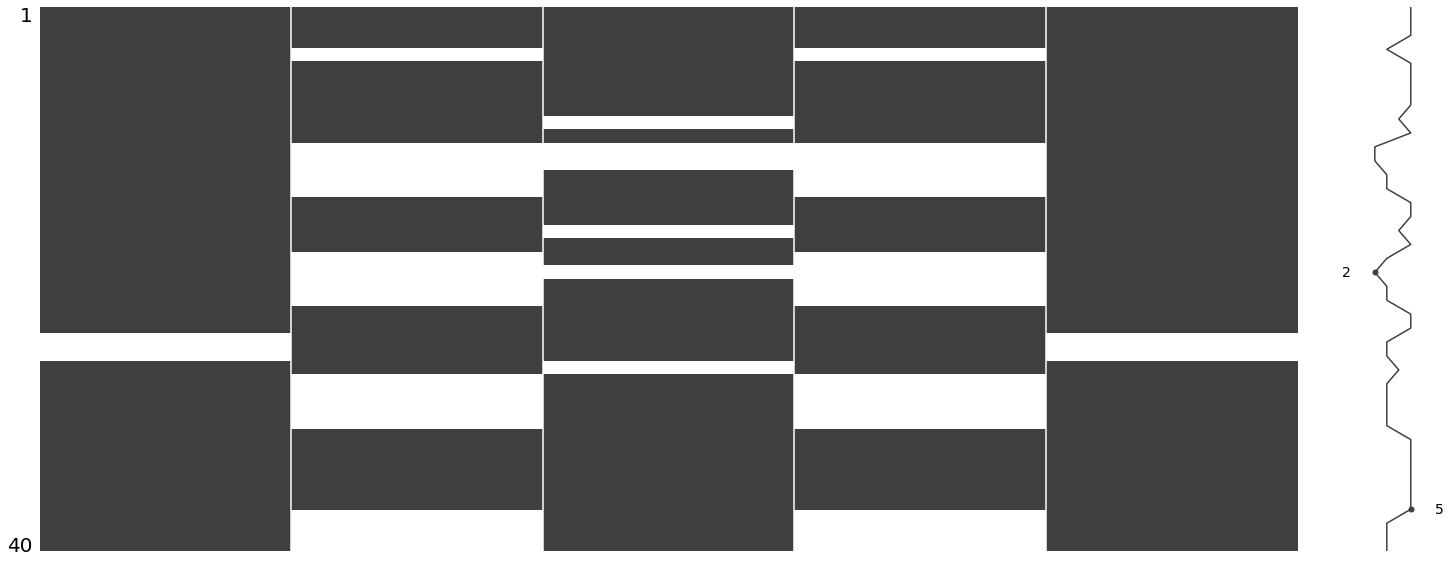

In [11]:
# 可视化呈现 No.313 样本 中属性中属性值存在空值的属性的分布
import missingno as msno
%matplotlib inline
msno.matrix(raw_313[raw_313_dummy_columns].replace(0, np.nan), labels=False)

In [12]:
# 对 No.313 样本中 存在属性值缺失的 属性进行统计学描述
dummy_raw_313 = raw_313[raw_313_dummy_columns].replace(0, np.NaN)
dummy_raw_313.describe()

,S-ZORB.FT_1204.PV,S-ZORB.FC_2432.DACA,S-ZORB.FT_2431.DACA,S-ZORB.FC_2432.PIDA.SP,S-ZORB.FT_1204.DACA.PV
,Unnamed: 109_level_1,D-106热氮气流量,Unnamed: 175_level_1,3.0步骤FIC2432.SP,D-121含硫污水排量
count,38.000000,24.000000,34.000000,24.000000,38.000000
mean,49.707433,55.025050,255.479771,55.977408,49.707433
std,8.341846,25.134146,234.464315,25.826184,8.341846
min,6.597014,0.488710,3.981225,0.177480,6.597014
25%,46.641427,38.959682,90.305070,39.000000,46.641427
50%,51.932390,68.763040,197.265750,69.000000,51.932390
75%,53.980428,74.201170,333.157850,79.000000,53.980428
max,57.424220,80.166200,937.010600,79.000000,57.424220


In [13]:
raw_313_filter = raw_313.drop(raw_313[['S-ZORB.FT_2431.DACA']], axis=1).replace(0, np.NaN)
raw_313_filter_describe = raw_313_filter.describe()
temp_ratio = raw_313_filter_describe.loc['std'] / raw_313_filter_describe.loc['mean']
for (code_name, i18n_name) in temp_ratio.keys():
    if temp_ratio[(code_name, i18n_name)] > 0.3:
        print(f"{'='*10} code_name: {code_name} {'='*10}")
        print(f"样本数据 参照 => {sample_313[(code_name, i18n_name)]}")
        print(f"原始数据 均值 => {raw_313_filter_describe.loc['mean', (code_name, i18n_name)]}")
        print(f"原始数据 方差 => {raw_313_filter_describe.loc['std', (code_name, i18n_name)]}")
        print(f"{'='*40}")
        print(f"变异系数 => {temp_ratio[(code_name, i18n_name)]}")
        norm_test = stats.kstest(raw_313_filter[(code_name, i18n_name)], 'norm', (raw_313_filter_describe.loc['mean', (code_name, i18n_name)], raw_313_filter_describe.loc['std', (code_name, i18n_name)]))
        
        print(f"正态检验 => {norm_test.pvalue}")
        if norm_test.pvalue > 0.05:
            print(f"正态分布检验成功，依据3σ原则进行修正")
            temp_data = raw_313_filter[(code_name, i18n_name)][np.abs(raw_313_filter[(code_name, i18n_name)] - raw_313_filter_describe.loc['mean', (code_name, i18n_name)]) <= 3 * raw_313_filter_describe.loc['std', (code_name, i18n_name)]]
            print(f"修正数据 均值 => {temp_data.mean()}")
            sample_313[(code_name, i18n_name)] = temp_data.mean()
            print(f"样本数据 修正 => {sample_313[(code_name, i18n_name)]}")
        else:
            print(f"正态分布检验失败，不对样本数据进行修正")
        print(f"{'='*40}")

========== code_name: S-ZORB.PDC_2502.PV ==========
样本数据 参照 => 44.47553984299999
原始数据 均值 => 44.475539843
原始数据 方差 => 32.09303634057142
变异系数 => 0.7215884608452379
正态检验 => 0.23137618121257653
正态分布检验成功，依据3σ原则进行修正
修正数据 均值 => 44.475539843
样本数据 修正 => 44.475539843
========== code_name: S-ZORB.FC_2432.DACA ==========
样本数据 参照 => 33.015029767499996
原始数据 均值 => 55.025049612500005
原始数据 方差 => 25.13414568536101
变异系数 => 0.45677642932376933
正态检验 => nan
正态分布检验失败，不对样本数据进行修正
========== code_name: S-ZORB.PDT_3602.DACA ==========
样本数据 参照 => 0.25898975500000004
原始数据 均值 => 0.258989755
原始数据 方差 => 0.12831749812724835
变异系数 => 0.4954539538726092
正态检验 => 0.24438277364119265
正态分布检验成功，依据3σ原则进行修正
修正数据 均值 => 0.258989755
样本数据 修正 => 0.258989755
========== code_name: S-ZORB.LT_9101.DACA ==========
样本数据 参照 => 1.6824734924999998
原始数据 均值 => 1.6824734925000002
原始数据 方差 => 2.109765974373722
变异系数 => 1.2539668433282742
正态检验 => 0.1964290696460399
正态分布检验成功，依据3σ原则进行修正
修正数据 均值 => 1.6824734925000002
样本数据 修正 => 1.6824734925000002
=====

### 处理 No.285 样本
- 将 No.285 样本的原始数据进行处理，先将属于285号样本的原始数据从表中剥离出来
- 对每一列操作属性进行均值、最大值、最小值、标准差求取，以判断其是否有异常值
- 最后对 No.285 号样本进行 样本确定法 求取每一个操作属性的均值

In [ ]:
# 取出 No.285 样本的描述属性中的均值一行
var_raw_285_mean = raw_285_describe.iloc[1]
# 将 No.285 样本的 原始数据均值 直接替换到 样本数据 中（《附件二：样本确定法》）
for (code_key, i18n_key) in var_raw_285_mean.keys():
    samples.loc[284, code_key][0] = var_raw_285_mean[code_key][0]

In [ ]:
# 查看样本点的描述属性
raw_313_describe = raw_313.describe()
raw_313_describe

In [ ]:
df = pd.read_excel(io=sample_data, header=[0, 1], skiprows=[0])
df.iloc[312, :22]

### 问题二：

寻找建模主要变量：建立降低辛烷值损失模型涉及包括7个原料性质、2个待生吸附剂性质、2个再生吸附剂性质、2个产品性质等变量以及另外354个操作变量（共计367个变量），工程技术应用中经常使用先降维后建模的方法，这有利于忽略次要因素，发现并分析影响模型的主要变量与因素。因此，请你们根据提供的325个样本数据（见附件一），通过降维的方法从367个操作变量中筛选出建模主要变量，使之尽可能具有代表性、独立性（为了工程应用方便，建议降维后的主要变量在30个以下），并请详细说明建模主要变量的筛选过程及其合理性。（提示：请考虑将原料的辛烷值作为建模变量之一）。

即 特征工程 -- 特征选择&数据降维

解题思路：
+ 特征选择
    - 数据值是否缺失过多：如果一个特征的样本数据缺失较多，则无法统计其对目标的影响，将该变量删除
        - 具体方法：分别统计操作变量的缺失值数量，然后计算其在数据中的比例，超过一定比例的特征可以删除
    - 特征是否发散：如果一个特征不发散，也就是说样本在这个特征上基本上没有差异，这个特征对于样本的区分并没有什么用
        - 具体方法：分别计算操作变量的方差，按方差的大小（需要结合《附件四：354个操作变量信息.xlsx》中的变量阈值进行归一化处理）进行排序（从大到小排），末尾删除一定数量
    - 特征与目标的相关性：这点比较显见，与目标相关性高的特征，应当优选选择，反之则相反
        - 具体方法：利用决策树算法，即采用方差的方法对特征值进行判别，每次选取一个特征值时会

> 在特征选择步骤中如果处理后存在未删除的缺失数据，需要考虑对缺失数据的补充，可以考虑对该数据的分布进行概率分布建模（例如：高斯分布）来确定其值，需要，即在进行数据降维操作之前，需要对数据完整性进行保证

+ 数据降维 (需要注意：“它们的操作变量（控制变量）之间具有高度非线性和相互强耦联的关系”题干中已经明确说明了)
    - 特征之间的相关性：因为操作变量之间是非线性关系，因此无法使用常规的线性降维方式，需要采用流形学习和核化方式对操作变量进行降维
        - 具体方法：利用t-SNE对操作变量进行降维
        

In [ ]:
df = pd.read_excel(io=sample_data, header=[0, 1], skiprows=[0])
df.iloc[284, :22]